In [1]:
import os, sys, importlib
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Ensure Python can find the local kerr_cpp extension
# (this allows running the notebook without installing)
# ---------------------------------------------------------

# Get the project root = parent directory of this notebook
PROJECT_ROOT = os.path.abspath("..")
sys.path.insert(0, PROJECT_ROOT)

# Remove any cached version
if "kerr_cpp" in sys.modules:
    del sys.modules["kerr_cpp"]

import kerr_cpp
importlib.reload(kerr_cpp)

print("Loaded kerr_cpp from:", kerr_cpp.__file__)
%matplotlib inline

Loaded kerr_cpp from: c:\Users\dyuma\Projects\kerr_black_hole\kerr_cpp.cp313-win_amd64.pyd


Make a starfield for the camera to view.

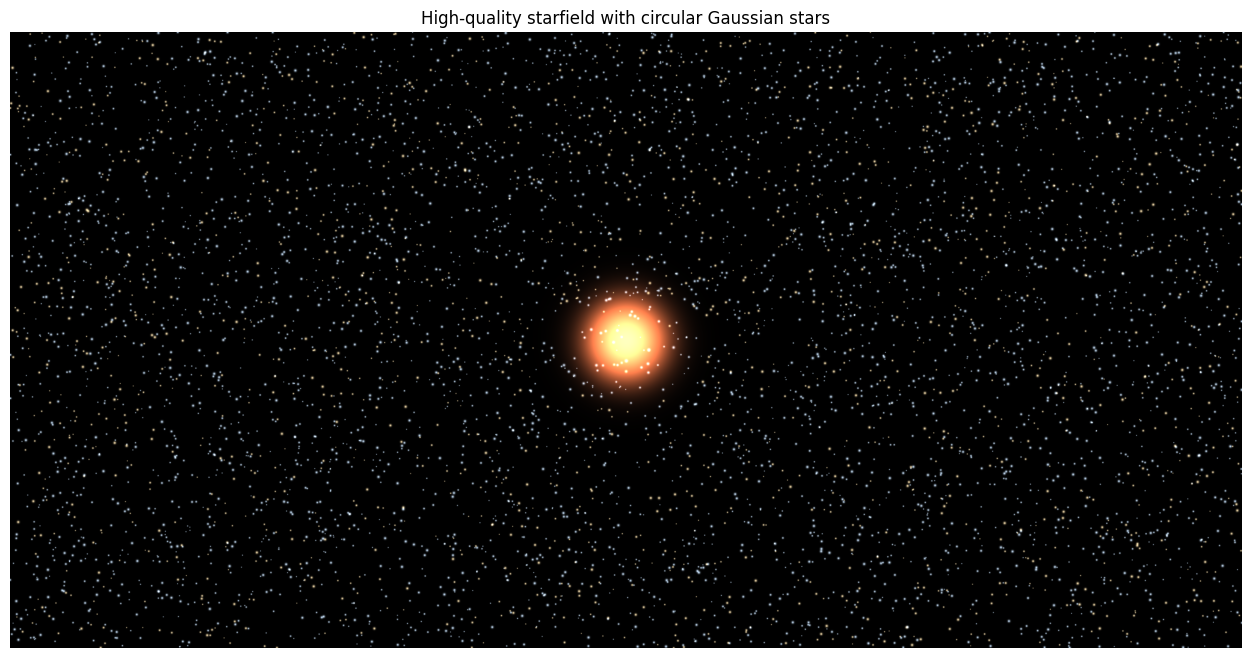

In [2]:
def make_starfield_smooth(
    height=1024,
    width=2048,
    n_stars=5000,
    big_star=False,
    seed=0
):
    """
    Produce a high-quality starfield with circular stars (Gaussian PSF),
    suitable for gravitational lensing visualization.
    """
    rng = np.random.default_rng(seed)
    img = np.zeros((height, width, 3), dtype=np.float64)

    # Background darkness
    img += 0.002

    # ------------------------------------------------------------
    # Small stars
    # ------------------------------------------------------------
    ys = rng.uniform(0, height, size=n_stars)
    xs = rng.uniform(0, width,  size=n_stars)

    # Gaussian widths (random star sizes)
    sigmas = rng.uniform(0.5, 1.5, size=n_stars)

    for x0, y0, s in zip(xs, ys, sigmas):
        # Random color temperature-ish variation
        if rng.random() < 0.7:
            color = np.array([0.8, 0.9, 1.0])  # blueish-white
        else:
            color = np.array([1.0, 0.9, 0.7])  # warm

        # A tiny 5×5 sampling window around star center
        ix0 = int(x0)
        iy0 = int(y0)

        for dx in range(-4, 5):
            for dy in range(-4, 5):
                xx = ix0 + dx
                yy = iy0 + dy
                if 0 <= xx < width and 0 <= yy < height:
                    # True subpixel Gaussian
                    r2 = ((xx + 0.5 - x0)**2 + (yy + 0.5 - y0)**2)
                    val = np.exp(-r2 / (2 * s * s))
                    img[yy, xx, :] += val * color

    # ------------------------------------------------------------
    # One big red giant (optional)
    # ------------------------------------------------------------
    if big_star:
        # place it near equator, mid longitudes
        cy = height * 0.5
        cx = width  * 0.5
        R  = height * 0.04

        color_big = np.array([1.0, 0.5, 0.3])

        y = np.arange(height)[:, None]
        x = np.arange(width)[None, :]
        r2 = (x - cx)**2 + (y - cy)**2
        g  = np.exp(-r2 / (2 * R**2))

        img += 2.5 * g[...,None] * color_big

    # Normalize
    img = np.clip(img, 0.0, 1.0)
    return img


# Create the high-quality starfield
sky_tex = make_starfield_smooth(
    height=1024,
    width=2048,
    n_stars=6000,
    big_star=True,     # turn on the red giant
    seed=0
)

plt.figure(figsize=(16,8))
plt.imshow(sky_tex)
plt.axis("off")
plt.title("High-quality starfield with circular Gaussian stars")
plt.show()


The cell below generates an animation of what the camera would record along a circular orbit in the equatorial plane. Feel free to adjust the black hole parameters and the radial coordinate.

In [ ]:
# ============================================================
# Kerr helpers: equatorial geodesic ICs in EF coords
# ============================================================

def kerr_equatorial_u_EF(r, M, a, E, Lz, inward=True):
    Sigma = r**2
    Delta = r**2 - 2.0*M*r + a*a

    A = E*(r*r + a*a) - a*Lz
    R = A*A - Delta*((Lz - a*E)**2 + r*r)

    if R < 0:
        raise RuntimeError(f"R(r0) < 0 for r={r}, E={E}, Lz={Lz}")

    ur_BL = -np.sqrt(R)/Sigma if inward else np.sqrt(R)/Sigma
    ut_BL = ((r*r + a*a)*A + a*(Lz - a*E)*Delta) / (Delta * Sigma)
    uphi_BL = (a*A + (Lz - a*E)*Delta) / (Delta * Sigma)

    uv = ut_BL + (r*r + a*a)/Delta * ur_BL
    ur = ur_BL
    uth = 0.0
    uphi_tilde = uphi_BL + a/Delta * ur_BL

    return np.array([uv, ur, uth, uphi_tilde], dtype=np.float64)


def horizon_radius(M, a):
    disc = M*M - a*a
    return M + np.sqrt(max(disc, 0.0))


# ============================================================
# 1. Choose constants and initial conditions
# ============================================================

M = 1.0
a = 0.9
r_start = 70.4

def kerr_circular_E_Lz(r0, M=1.0, a=0.0, prograde=True):
    r0 = float(r0); M = float(M); a = float(a)
    s = +1.0 if prograde else -1.0

    sqrtM  = np.sqrt(M)
    sqrt_r = np.sqrt(r0)

    denom_inner = r0**1.5 - 3.0*M*sqrt_r + 2.0*s*a*sqrtM
    if denom_inner <= 0.0:
        raise ValueError(f"r0={r0} too small for circular orbit.")

    denom = r0**0.75 * np.sqrt(denom_inner)

    num_E = r0**1.5 - 2.0*M*sqrt_r + s*a*sqrtM
    E = num_E / denom

    num_L = s * sqrtM * (r0**2 - 2.0*s*a*sqrtM*sqrt_r + a**2)
    Lz = num_L / denom
    return E, Lz

E, Lz = kerr_circular_E_Lz(r_start, M, a, prograde=True)

x0 = np.array([0.0, r_start, np.pi/2, 0.0], dtype=np.float64)
u0 = kerr_equatorial_u_EF(r_start, M, a, E, Lz, inward=True)

print("Initial u0 (EF coords):", u0)


# ============================================================
# 2. Integrate timelike geodesic with CORRECT API
# ============================================================

d_tau = 0.01
max_steps_geo = 370000

# Set horizon and integration stop radius
r_plus = horizon_radius(M, a)
r_min  = r_plus - 0.1     # fall slightly inside horizon; safe

# CORRECT FUNCTION:
# integrate_timelike_to_rmin(x0, u0, M, a, d_tau, r_min, max_steps_geo)
tau_total, X_traj, U_traj = kerr_cpp.integrate_timelike_to_rmin(
    x0,
    u0,
    M,
    a,
    d_tau,
    r_min,
    max_steps_geo
)

X_traj = np.asarray(X_traj)
U_traj = np.asarray(U_traj)

print("Timelike steps:", X_traj.shape[0])
print("r range:", X_traj[:,1].min(), "→", X_traj[:,1].max())

phi = np.unwrap(X_traj[:,3])
delta_phi = phi[-1] - phi[0]
print("Total Δφ ≈", delta_phi/(2*np.pi), "orbits")


# ============================================================
# 3. Choose frames along the trajectory
# ============================================================

n_frames = 200
n_steps  = X_traj.shape[0]
n_frames = min(n_frames, n_steps)

frame_idxs = np.linspace(0, n_steps - 1, num=n_frames, dtype=int)
print("Using", n_frames, "frames")


# ============================================================
# 4. Render each frame along the orbit (in memory only)
# ============================================================

width   = 512
height  = 512
fov_deg = 80.0

dl             = 0.01
max_steps_null = 100000
r_escape       = 400.0

# Camera orientation (degrees)
yaw_deg   = 0.0
pitch_deg = 0.0
roll_deg  = 0.0

sky_tex_np = np.ascontiguousarray(sky_tex.astype(np.float64))

frames = []

for k, idx in enumerate(frame_idxs):
    x_obs = X_traj[idx]
    u_obs = U_traj[idx]

    img = kerr_cpp.render_frame_full(
        x_obs, u_obs,
        width, height,
        fov_deg,
        M, a,
        dl,
        max_steps_null,
        r_escape,
        sky_tex_np,
        yaw_deg,
        pitch_deg,
        roll_deg
    )

    img = np.clip(np.asarray(img), 0.0, 1.0)
    frames.append(img)

    pct = 100.0 * (k + 1) / n_frames
    print(f"Rendering progress: {k+1}/{n_frames} frames ({pct:5.1f}%)")



# ============================================================
# 5. Save movie to media/
# ============================================================

from pathlib import Path

MEDIA_DIR = Path("media")
MEDIA_DIR.mkdir(exist_ok=True)

frames_u8 = [(f * 255).astype(np.uint8) for f in frames]

gif_path = MEDIA_DIR / f"kerr_orbit_E1_Lz{Lz:.2f}.gif"

imageio.mimsave(
    gif_path,
    frames_u8,
    fps=24,
    loop=0   # infinite loop
)

print("Saved GIF:", gif_path)

Now, for another, more complicated orbit (again, feel free to adjust the parameters):

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import kerr_cpp
import os

# ============================================================
# 1. Physical parameters and initial conditions
# ============================================================

M = 1.0
a = 0.9

# Start far away, slightly above equator
r_start = 100.0
theta_start = np.pi/2 + 0.01    
phi_start = 0.0
v_start = 0.0

x0 = np.array([v_start, r_start, theta_start, phi_start], dtype=np.float64)

# Spiral inward initial 4-velocity guess (unnormalized)
u_r   = 0.0
u_th  = -0.0004     # downward to cross equator
u_phi = 0.0002      # angular momentum → spiral
u0 = np.array([1.0, u_r, u_th, u_phi], dtype=np.float64)

print("Initial x0:", x0)
print("Initial (unnormalized) u0:", u0)

# ============================================================
# 2. Integrate the timelike geodesic — CORRECT API
# ============================================================

d_tau = 0.005
max_steps_geo = 610000

# Fall *inside* the horizon
r_plus = M + np.sqrt(M*M - a*a)
r_min  = r_plus - 0.1     # safe and physically meaningful

# Correct function:
# integrate_timelike_to_rmin(x0, u0, M, a, d_tau, r_min, max_steps_geo)
tau_total, X_traj, U_traj = kerr_cpp.integrate_timelike_to_rmin(
    x0,
    u0,
    M,
    a,
    d_tau,
    r_min,
    max_steps_geo
)

X_traj = np.asarray(X_traj)
U_traj = np.asarray(U_traj)

print("Total steps integrated:", X_traj.shape[0])
print("Minimum r reached:", X_traj[:,1].min())

# ============================================================
# 3. Choose frames along trajectory
# ============================================================

n_frames = 200
n_steps  = X_traj.shape[0]
frame_idxs = np.linspace(0, n_steps - 1, num=n_frames, dtype=int)

print("Using", n_frames, "frames")

# ============================================================
# 4. Render each frame — in memory only
# ============================================================

width   = 512
height  = 512
fov_deg = 80.0

dl             = 0.01
max_steps_null = 100000
r_escape       = 400.0

# Camera orientation (degrees)
yaw_deg   = 0.0
pitch_deg = 0.0
roll_deg  = 0.0

sky_tex_np = np.ascontiguousarray(sky_tex.astype(np.float64))

frames = []

for k, idx in enumerate(frame_idxs):
    x_obs = X_traj[idx]
    u_obs = U_traj[idx]

    img = kerr_cpp.render_frame_full(
        x_obs, u_obs,
        width, height,
        fov_deg,
        M, a,
        dl,
        max_steps_null,
        r_escape,
        sky_tex_np,
        yaw_deg,
        pitch_deg,
        roll_deg
    )

    img = np.clip(np.asarray(img), 0.0, 1.0)
    frames.append(img)

    pct = 100.0 * (k + 1) / n_frames
    print(f"Rendering progress: {k+1}/{n_frames} frames ({pct:5.1f}%)")

# ============================================================
# 5. Save movie to media/
# ============================================================

from pathlib import Path

MEDIA_DIR = Path("media")
MEDIA_DIR.mkdir(exist_ok=True)

frames_u8 = [(f * 255).astype(np.uint8) for f in frames]

gif_path = MEDIA_DIR / "spiral_infall.gif"

imageio.mimsave(
    gif_path,
    frames_u8,
    fps=24,
    loop=0   # infinite loop
)

print("Saved GIF:", gif_path)
